In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0621/weights_KD_segformer_0621_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 742ms/step - loss: 0.0147
Average validation loss: 0.4458920955657959
4/4 [==============================] - 7s 754ms/step - loss: 0.0147 - val_loss: 0.4459
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 762ms/step - loss: 0.0081 - val_loss: 0.4459
Average validation loss: 0.2983674108982086
4/4 [==============================] - 11s 781ms/step - loss: 0.0081 - val_loss: 0.3721
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 766ms/step - loss: 0.0055 - val_loss: 0.3721
Average validation loss: 0.19402463734149933
4/4 [==============================] - 14s 778ms/step - loss: 0.0055 - val_l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 714ms/step - loss: 3.3918e-05
Average validation loss: 4.9806845709099434e-05
8/8 [==============================] - 6s 724ms/step - loss: 3.3918e-05 - val_loss: 4.9807e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 684ms/step - loss: 3.3222e-05 - val_loss: 4.9807e-05
Average validation loss: 0.00044699142745230347
8/8 [==============================] - 11s 693ms/step - loss: 3.3222e-05 - val_loss: 2.4840e-04
Epoch 3/10
8/8 [==============================] - 17s 705ms/step - loss: 3.2831e-05 - val_loss: 2.4840e-04
Average validation loss: 0.0009913260582834482
8/8 [==============================] - 17s 717ms/step - loss: 3.2831e-05 - val_loss: 4.9604e-04
Epoch 4/10
8/8 [==============================] - 23s 714ms/step - loss: 3.2324e-05 - val_loss: 4.9604e-04
A

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 764ms/step - loss: 6.3322e-05
Average validation loss: 0.03387637149232129
12/12 [==============================] - 9s 774ms/step - loss: 6.3322e-05 - val_loss: 0.0339
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 699ms/step - loss: 6.4355e-05 - val_loss: 0.0339
Average validation loss: 0.03771779618546134
12/12 [==============================] - 18s 710ms/step - loss: 6.4355e-05 - val_loss: 0.0358
Epoch 3/10
12/12 [==============================] - 26s 699ms/step - loss: 7.1166e-05 - val_loss: 0.0358
Average validation loss: 0.03427906759316102
12/12 [==============================] - 26s 711ms/step - loss: 7.1166e-05 - val_loss: 0.0353
Epoch 4/10
12/12 [==============================] - 35s 696ms/step - loss: 6.7089e-05 - val_loss: 0.0353
Average validation 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 697ms/step - loss: 4.3108e-05
Average validation loss: 0.07976718429119956
16/16 [==============================] - 11s 708ms/step - loss: 4.3108e-05 - val_loss: 0.0798
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 697ms/step - loss: 4.3420e-05 - val_loss: 0.0798
Average validation loss: 0.10948626028900676
16/16 [==============================] - 23s 709ms/step - loss: 4.3420e-05 - val_loss: 0.0946
Epoch 3/10
16/16 [==============================] - 34s 703ms/step - loss: 4.2180e-05 - val_loss: 0.0946
Average validation loss: 0.05556525450083427
16/16 [==============================] - 34s 714ms/step - loss: 4.2180e-05 - val_loss: 0.0816
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weig

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 717ms/step - loss: 2.6702e-05
Average validation loss: 0.09770411354556927
20/20 [==============================] - 15s 727ms/step - loss: 2.6702e-05 - val_loss: 0.0977
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 711ms/step - loss: 2.2919e-05 - val_loss: 0.0977
Average validation loss: 0.09666970199032221
20/20 [==============================] - 29s 722ms/step - loss: 2.2919e-05 - val_loss: 0.0972
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 727ms/step - loss: 2.0734e-05 - val_loss: 0.0972
Average validation loss: 0.07687729622812185
20/20 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 725ms/step - loss: 4.9102e-05
Average validation loss: 0.03757593035697937
24/24 [==============================] - 18s 736ms/step - loss: 4.9102e-05 - val_loss: 0.0376
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 699ms/step - loss: 4.1594e-05 - val_loss: 0.0376
Average validation loss: 0.049344390630722046
24/24 [==============================] - 35s 709ms/step - loss: 4.1594e-05 - val_loss: 0.0435
Epoch 3/10
24/24 [==============================] - 52s 698ms/step - loss: 3.4888e-05 - val_loss: 0.0435
Average validation loss: 0.03517719885955254
24/24 [==============================] - 52s 708ms/step - loss: 3.4888e-05 - val_loss: 0.0407
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 708ms/step - loss: 9.0773e-05
Average validation loss: 0.07869705259799957
40/40 [==============================] - 29s 718ms/step - loss: 9.0773e-05 - val_loss: 0.0787
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 698ms/step - loss: 7.2969e-05 - val_loss: 0.0787
Average validation loss: 0.08188501894474029
40/40 [==============================] - 57s 708ms/step - loss: 7.2969e-05 - val_loss: 0.0803
Epoch 3/10
40/40 [==============================] - 85s 689ms/step - loss: 6.3293e-05 - val_loss: 0.0803
Average validation loss: 0.08617148026823998
40/40 [==============================] - 85s 699ms/step - loss: 6.3293e-05 - val_loss: 0.0823
Epoch 4/10
40/40 [==============================] - 113s 709ms/step - loss: 5.7519e-05 - val_loss: 0.0823
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 715ms/step - loss: 5.1361e-05
Average validation loss: 0.07843682127349894
48/48 [==============================] - 35s 726ms/step - loss: 5.1361e-05 - val_loss: 0.0784
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 707ms/step - loss: 4.3535e-05 - val_loss: 0.0784
Average validation loss: 0.05133440527909746
48/48 [==============================] - 69s 717ms/step - loss: 4.3535e-05 - val_loss: 0.0649
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 104s 721ms/step - loss: 3.5732e-05 - val_loss: 0.0649
Average validation loss: 0.04903729143552482
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 703ms/step - loss: 4.9476e-05
Average validation loss: 0.11230791276323414
56/56 [==============================] - 40s 713ms/step - loss: 4.9476e-05 - val_loss: 0.1123
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 712ms/step - loss: 3.5763e-05 - val_loss: 0.1123
Average validation loss: 0.07118408513802674
56/56 [==============================] - 80s 722ms/step - loss: 3.5763e-05 - val_loss: 0.0917
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 713ms/step - loss: 2.8341e-05 - val_loss: 0.0917
Average validation loss: 0.08790399796894885
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 705ms/step - loss: 3.1968e-05
Average validation loss: 0.04806101234862581
64/64 [==============================] - 46s 715ms/step - loss: 3.1968e-05 - val_loss: 0.0481
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 707ms/step - loss: 2.3185e-05 - val_loss: 0.0481
Average validation loss: 0.023108772293198854
64/64 [==============================] - 92s 717ms/step - loss: 2.3185e-05 - val_loss: 0.0356
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 137s 712ms/step - loss: 1.8469e-05 - val_loss: 0.0356
Average validation loss: 0.027345535287167877
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 718ms/step - loss: 3.3487e-05
Average validation loss: 0.046280325286918216
72/72 [==============================] - 52s 728ms/step - loss: 3.3487e-05 - val_loss: 0.0463
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 722ms/step - loss: 2.3280e-05 - val_loss: 0.0463
Average validation loss: 0.037794605207939945
72/72 [==============================] - 105s 733ms/step - loss: 2.3280e-05 - val_loss: 0.0420
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 156s 705ms/step - loss: 1.8579e-05 - val_loss: 0.0420
Average validation loss: 0.04009886013550891
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 707ms/step - loss: 2.7636e-05
Average validation loss: 0.04949588812887669
80/80 [==============================] - 57s 717ms/step - loss: 2.7636e-05 - val_loss: 0.0495
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 704ms/step - loss: 2.0422e-05 - val_loss: 0.0495
Average validation loss: 0.04693174874410033
80/80 [==============================] - 115s 714ms/step - loss: 2.0422e-05 - val_loss: 0.0482
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 172s 711ms/step - loss: 1.5725e-05 - val_loss: 0.0482
Average validation loss: 0.04615624854341149
80/80 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 707ms/step - loss: 5.9109e-05
Average validation loss: 0.12786256615625766
96/96 [==============================] - 69s 717ms/step - loss: 5.9109e-05 - val_loss: 0.1279
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 703ms/step - loss: 3.9407e-05 - val_loss: 0.1279
Average validation loss: 0.08633123810318466
96/96 [==============================] - 137s 713ms/step - loss: 3.9407e-05 - val_loss: 0.1071
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 705ms/step - loss: 2.9525e-05 - val_loss: 0.1071
Average validation loss: 0.08623488261552363
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 709ms/step - loss: 3.5907e-05
Average validation loss: 0.07703084101279577
120/120 [==============================] - 86s 719ms/step - loss: 3.5907e-05 - val_loss: 0.0770
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 705ms/step - loss: 2.6272e-05 - val_loss: 0.0770
Average validation loss: 0.05710702345822938
120/120 [==============================] - 172s 715ms/step - loss: 2.6272e-05 - val_loss: 0.0671
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 706ms/step - loss: 2.0413e-05 - val_loss: 0.0671
Average validation loss: 0.04575869669982543
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 707ms/step - loss: 2.1155e-05
Average validation loss: 0.07700026775182778
144/144 [==============================] - 103s 717ms/step - loss: 2.1155e-05 - val_loss: 0.0770
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 206s 712ms/step - loss: 1.5490e-05 - val_loss: 0.0770
Average validation loss: 0.07490889053497085
144/144 [==============================] - 207s 722ms/step - loss: 1.5490e-05 - val_loss: 0.0760
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 309s 704ms/step - loss: 1.2355e-05 - val_loss: 0.0760
Average validation loss: 0.08112658456143941
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 123s 771ms/step - loss: 1.2571e-05
Average validation loss: 0.10468901013681489
160/160 [==============================] - 125s 782ms/step - loss: 1.2571e-05 - val_loss: 0.1047
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 249s 772ms/step - loss: 9.2595e-06 - val_loss: 0.1047
Average validation loss: 0.10280513539556183
160/160 [==============================] - 250s 783ms/step - loss: 9.2595e-06 - val_loss: 0.1037
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 374s 773ms/step - loss: 1.2499e-05 - val_loss: 0.1037
Average validation loss: 0.11422348122299013
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 154s 770ms/step - loss: 5.5293e-05
Average validation loss: 0.09150246432836866
200/200 [==============================] - 156s 781ms/step - loss: 5.5293e-05 - val_loss: 0.0915
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 310s 768ms/step - loss: 3.8440e-05 - val_loss: 0.0915
Average validation loss: 0.08687094159715343
200/200 [==============================] - 312s 779ms/step - loss: 3.8440e-05 - val_loss: 0.0892
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 466s 769ms/step - loss: 3.0142e-05 - val_loss: 0.0892
Average validation loss: 0.08586607431912853
200/200 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:34 - loss: 8.0520e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 185s 771ms/step - loss: 2.6257e-05
Average validation loss: 0.10760036674114418
240/240 [==============================] - 188s 781ms/step - loss: 2.6257e-05 - val_loss: 0.1076
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 372s 770ms/step - loss: 1.7542e-05 - val_loss: 0.1076
Average validation loss: 0.10870351851504362
240/240 [==============================] - 375s 781ms/step - loss: 1.7542e-05 - val_loss: 0.1082
Epoch 3/10
240/240 [==============================] - 559s 767ms/step - loss: 1.3898e-05 - val_loss: 0.1082
Average validation loss: 0.11873798711936084
240/240 [==============================] - 562s 778ms/step - loss: 1.3898e-05 - val_loss: 0.1117
Epoch 4/10
240/240 [==============================] - 746s 769ms/step - loss: 1.2139e-05 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.04782535536553041, 0.040220725349380475, 0.08718398774159508, 0.09011088870372994, 0.048106316449640876, 0.033696877556212715, 0.06392872044794058, 0.0518260513338464, 0.047352209062139855, 0.04209314378425916, 0.04971514380379327, 0.05818862195441898, 0.05901934677747401, 0.06971608976001714, 0.07627698076124419, 0.08747942413738591, 0.10703755798460374, 0.1070042010252907]
std_val_losses =  [0.07913962553199803, 0.03201097831826051, 0.04412780404926241, 0.032660315160446644, 0.021313140734617347, 0.015101972508152041, 0.030216202335266992, 0.01831810071843704, 0.022221446054223878, 0.009779393106222558, 0.01477467063945475, 0.019075605376532145, 0.020409993476601853, 0.02446536583381985, 0.01236161261463986, 0.015908393877452343, 0.01910992627172559, 0.011879101168422963]


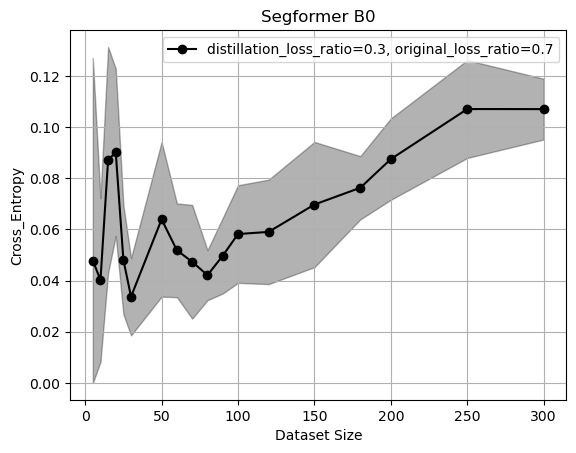

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0621')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0621_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0621_{int(teacher_ratio*100)}.png"))

plt.show()